In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 64
SAMPLE_SIZE= 50000
BINS = 25

In [3]:
filenames = {
    "herwig": "../GAN-data/events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2"]
condition_features = ["mjj"]

features = train_features + condition_features
GEN_DIM = NOISE_DIM + len(condition_features)
DISC_DIM = len(features)

In [4]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

np_bg_SB = np.load('./data/processed/np_bg_SB_2.npy')
np_bg_SR = np.load('./data/processed/np_bg_SR_2.npy')
np_sig_SR = np.load('./data/processed/np_sig_SR_2.npy')

np_sig_SR_labeled = np.copy(np_sig_SR)
np_bg_SR_labeled = np.copy(np_bg_SR)
#add sb label
np_sig_SR_labeled = np.append(np_sig_SR_labeled,np.ones([len(np_sig_SR),1]),1)
np_bg_SR_labeled = np.append(np_bg_SR_labeled,np.zeros([len(np_bg_SR),1]),1)

np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
np_combined_SR_labeled = np.concatenate((np_sig_SR_labeled,np_bg_SR_labeled),axis=0)

gc.collect()

9

In [5]:
def generate_gan(generator, realdata):

    labels = sample_fake(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)
    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)
    return fakedata
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
def sample_fake(refdata = np_combined_SR, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))
def sample_data(refdata = np_combined_SR_labeled,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]


In [6]:
np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [7]:
gen_model = tf.keras.models.load_model('./Results/epoch1000-generator.h5')

In [8]:
generated_data = generate_gan(gen_model,np_combined_SR)
generated_data2 = generate_gan(gen_model,np_combined_SR)
generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
generated_data_labeled  = np.copy(generated_data)
generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()


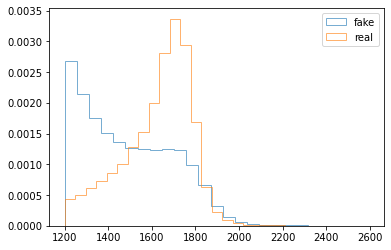

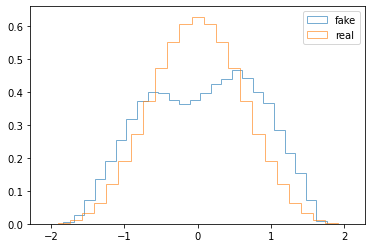

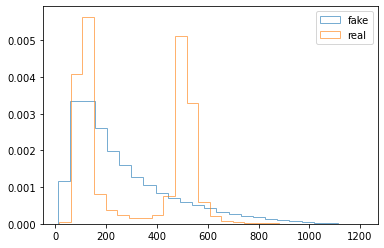

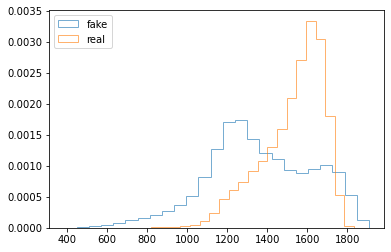

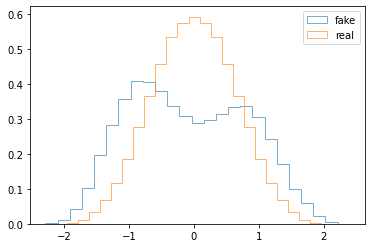

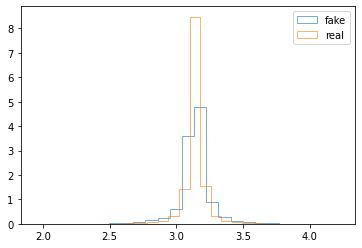

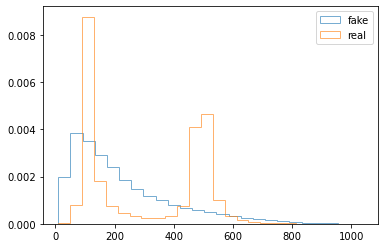

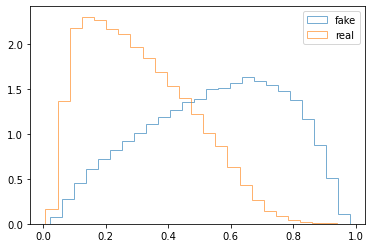

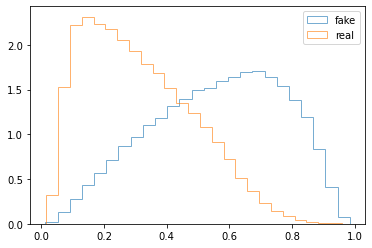

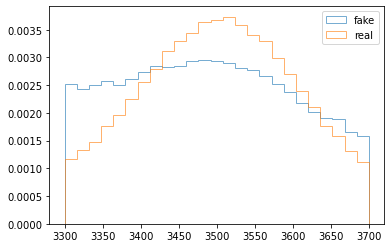

In [11]:
for i in range(0,10):
    plt.hist(generated_data[:,i],25,alpha=0.6,histtype = 'step',label = 'fake',density = True)
    plt.hist(np_sig_SR[:,i],25,alpha = 0.6,histtype = 'step',label = 'real',density = True)
    plt.legend()
    plt.show()

In [32]:
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()

In [16]:
classifier = classifier_model()
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [22]:
dataset = np.concatenate((np_sig_SR_labeled, generated_data_labeled), axis = 0)
print(np_sig_SR_labeled.shape)
print(generated_data_labeled.shape)

(150596, 11)
(100000, 11)


In [26]:
dataset_df = pd.DataFrame(dataset, columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sblabel'])

In [27]:
dataset_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sblabel
0,1914.942993,0.369530,105.035004,1583.804443,-0.185737,2.898982,461.574005,0.552809,0.121353,3662.211182,1.0
1,1684.598755,-0.523116,159.865997,1647.186768,0.110357,3.141156,514.883972,0.440781,0.299984,3586.710693,1.0
2,1789.997070,0.156652,93.665901,1569.509399,0.144243,3.235663,475.316986,0.136103,0.135523,3421.777344,1.0
3,1672.631348,-1.015185,116.327003,1568.322998,-0.350886,3.165926,561.236023,0.617014,0.294746,3536.982910,1.0
4,1431.694946,-0.700751,513.015991,1099.721313,0.945019,3.245961,108.752998,0.183145,0.456454,3481.573486,1.0
...,...,...,...,...,...,...,...,...,...,...,...
250591,1683.837730,-0.470907,169.825177,1712.677758,-0.830393,3.100222,134.681186,0.758864,0.359449,3320.123047,0.0
250592,1522.080659,0.790946,66.751315,1421.189774,-0.632003,3.177119,84.207564,0.517772,0.534937,3584.108643,0.0
250593,1708.056036,-0.094127,387.330998,1714.632146,0.311656,3.122409,299.487519,0.551747,0.829335,3432.143555,0.0
250594,1597.996215,0.585437,445.838345,1610.177851,-0.426327,3.109872,97.620510,0.128635,0.338127,3535.938721,0.0


Train on 150357 samples, validate on 50119 samples
Epoch 1/10
150357/150357 [==============================] - 6s 39us/sample - loss: 0.7059 - tp: 74924.0000 - fp: 25172.0000 - tn: 35099.0000 - fn: 15162.0000 - accuracy: 0.7317 - precision: 0.7485 - recall: 0.8317 - auc: 0.7591 - val_loss: 0.4544 - val_tp: 25917.0000 - val_fp: 5540.0000 - val_tn: 14489.0000 - val_fn: 4173.0000 - val_accuracy: 0.8062 - val_precision: 0.8239 - val_recall: 0.8613 - val_auc: 0.8605
Epoch 2/10
150357/150357 [==============================] - 4s 28us/sample - loss: 0.4637 - tp: 76585.0000 - fp: 15295.0000 - tn: 44976.0000 - fn: 13501.0000 - accuracy: 0.8085 - precision: 0.8335 - recall: 0.8501 - auc: 0.8555 - val_loss: 0.4379 - val_tp: 24485.0000 - val_fp: 3610.0000 - val_tn: 16419.0000 - val_fn: 5605.0000 - val_accuracy: 0.8161 - val_precision: 0.8715 - val_recall: 0.8137 - val_auc: 0.8749
Epoch 3/10
150357/150357 [==============================] - 4s 28us/sample - loss: 0.4328 - tp: 76298.0000 - fp: 12638.

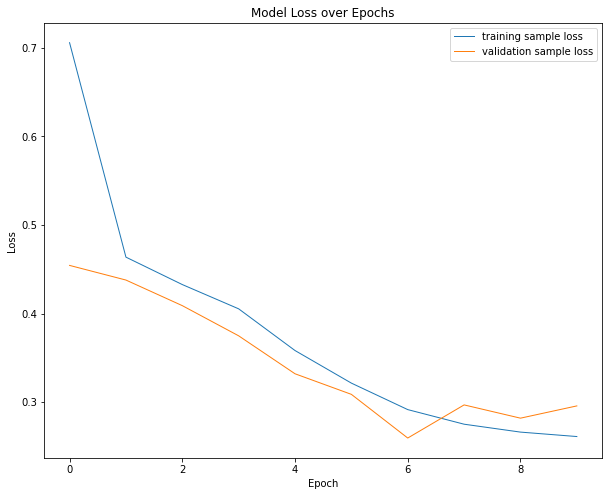

In [33]:
x_train,x_test,y_train,y_test = train_test_split(dataset[:,[2,6,7,8]],dataset[:,-1], test_size = 0.2, random_state=1) #rf label
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2, #rflabel

classifier = classifier_model()
history = classifier.fit(x_train, y_train, epochs=10, batch_size=128,validation_data=(x_val,y_val))
learningCurveLoss(history)
y_pred = classifier.predict(x_test) #predict on signal vs background in test sample
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_value = auc(fpr,tpr)


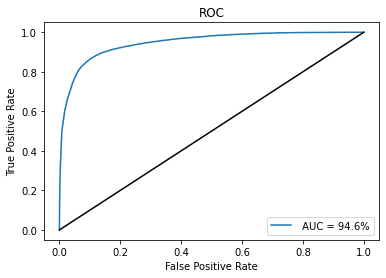

In [35]:
plot_roc_curve(y_test,y_pred)